In [33]:
using NBInclude
using Plots.PlotMeasures

@nbinclude("functions.ipynb")

All function imported


In [3]:
function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST.testdata(Float32)
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

function load_model_sep(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar W1 W2 W3 Q
    println("Done")
    return encoder_μ, encoder_logvar, W1, W2, W3, Q
end

function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder decoder_last
    println("Done")
    return encoder_μ, encoder_logvar, decoder, decoder_last
    
end

# setup
# experiments with MNIST dataset
x_dim = 784
k = 20

tolerance = 1e-7; max_iter = 6000; out_toggle = 0
trials = 20
opt = Flux.Optimise.ADAM(.1);

# encoder_μ_inco, encoder_logvar_inco,  W1_inco, W2_inco, W3_inco, Q_inco = load_model_sep("trained_GNN/MNIST_identity_v4", 25)
B = randn(x_dim, 500)/sqrt(x_dim)
_, _,  W1_co, W2_co, W3_co, Q_co = load_model_sep("trained_GNN/MNIST_v2", 25)
F = dct(diagm(ones(x_dim)),2);
β_list, α_list = get_β_α(F, Q_co, B, 40);
recovery_error_matrix = zeros(trials, 1 + length(β_list) )
recon_error_matrix = zeros(trials, 1 + length(β_list) );

m_list = 20:5:250

Loading model...Done

20:5:250

In [4]:
# save("saved_data/Phase_plot_full_MNIST.jld", "phase_matrix_recovery", phase_matrix_recovery, "phase_matrix_recon", phase_matrix_recon, "α_list", α_list, "m_list", m_list, "trials", trials)
phase_matrix_recovery =load("saved_data/Phase_plot_full_MNIST.jld", "phase_matrix_recovery")
phase_matrix_recon =load("saved_data/Phase_plot_full_MNIST.jld", "phase_matrix_recon")
α_list =load("saved_data/Phase_plot_full_MNIST.jld", "α_list")
m_list =load("saved_data/Phase_plot_full_MNIST.jld", "m_list")
trials =load("saved_data/Phase_plot_full_MNIST.jld", "trials")

20

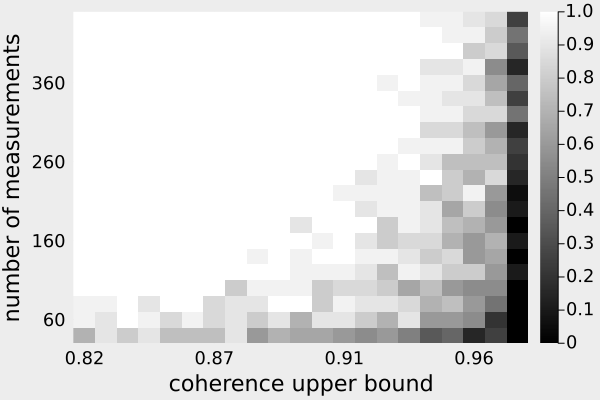

In [35]:
M = zeros(size(phase_matrix_recon[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-5)
end

# p1 = plot(colorview(Gray, reverse(M/trials, dims = 1)), bg =:black, title = "recovery of signal G(z₀)",framestyle = :box)
plot(heatmap(M/trials, c =:gist_gray),bg =:grey93,framestyle = :box, showaxis =:false,  xlabel = "coherence upper bound", ylabel = "number of measurements",  xlabelfontsize = 15, ylabelfontsize = 15, xtickfontsize = 12, ytickfontsize = 12, bottom_margin = 2mm)
xticks = 1:6:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:6:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[i])" for i in 2:5:length(m_list)])

# M = sum(phase_matrix_recon,dims =1)[1,:,:]/20; M[M .>1] .= 1
# plot(heatmap(log10.(M/trials)),bg =:white, title = "recovery of signal G(z₀)",framestyle = :box, showaxis =:false)


# p2 = plot(colorview(Gray, log10.(reverse(M,dims=1))), framestyle = :box, title = "recovery of signal G(z₀)")
# xticks = 1:5:length(α_list)
# xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
# yticks = 2:5:length(m_list)
# yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])


# plot(p1, p2, layout = 2, xlabel = "incoherence upper bound", ylabel = "number of measurements")
# savefig("figures/Phase_plot_Full_MNIST_percentage.pdf")
# log10.(M)
# M



In [36]:

savefig("figures/Phase_plot_Full_MNIST_percentage_paper_v2.png")

In [25]:

recon_error_matrix = phase_matrix_recon[:,4,:]

log_recon_error_matrix = log10.(recon_error_matrix)
average_recon = mean(log_recon_error_matrix, dims=1)'
std_recon = std(log_recon_error_matrix, dims=1)'
plot(α_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .2, c = cs[440], label = false, linecolor = invisible())
scatter!(kron(α_list',ones(trials,1))[:], log_recon_error_matrix[:], label =:false, c = cs[500])
plot!(α_list, average_recon, xlabel = "coherence upper bound", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1000], label =false, c = cs[400],  xlabelfontsize = 15, ylabelfontsize = 15, xtickfontsize = 12, ytickfontsize = 12  )
yticks = [-8:2:0;]
yticks!(yticks, [L"10^{%$y}" for y in yticks])

savefig("figures/MNIST_error_100_meas_paper.pdf")

# plot(p1,p2,layout = 2, ylims = (minimum([ylims(p1)[1],ylims(p2)[1]]), maximum([ylims(p1)[2],ylims(p2)[2]]) ))



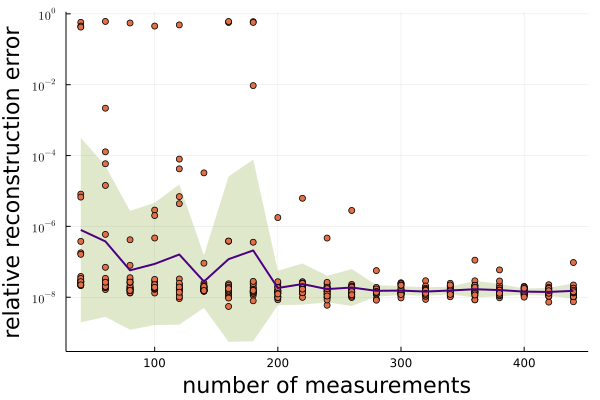

In [18]:

recon_error_matrix = phase_matrix_recon[:,:,15]

log_recon_error_matrix = log10.(recon_error_matrix)
average_recon = mean(log_recon_error_matrix, dims=1)'
std_recon = std(log_recon_error_matrix, dims=1)'
plot(m_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .2, c = cs[400], label = false, linecolor = invisible())
scatter!(kron(m_list',ones(trials,1))[:], log_recon_error_matrix[:], label =:false)
plot!(m_list, average_recon, xlabel = "number of measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1000], label =false, xlabelfontsize = 15, ylabelfontsize = 15 )
yticks = [-8:2:0;]
yticks!(yticks, [L"10^{%$y}" for y in yticks])


# plot(p1,p2,layout = 2, ylims = (minimum([ylims(p1)[1],ylims(p2)[1]]), maximum([ylims(p1)[2],ylims(p2)[2]]) ))



In [32]:
m_list[4]

100